# Neural Language Models

**Overview**: In this notebook, we’ll be looking at advanced forms of language modeling using *neural networks*. Additionally, we will learn how to build a character-level recurrent neural network, known as a char-RNN for short, with PyTorch.

  This notebook is divided into 2 sections:
  1. Classify simple and hard words
  2. Classify city names to country


In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.6 MB/s eta 0:00:00


In [ ]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


## Setup 2: Dataset / Packages
- **Run the following cells without changing anything!**

In [ ]:
#Import Packages
from os.path import exists
from sklearn.metrics import accuracy_score
import codecs
import math
import random
import string
import time
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
#Download and unzip files
!gdown 16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ # https://drive.google.com/file/d/16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ/view?usp=sharing
!gdown 17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk # https://drive.google.com/file/d/17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk/view?usp=sharing
!gdown 1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK # https://drive.google.com/file/d/1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK/view?usp=sharing
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!gdown 1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw # https://drive.google.com/file/d/1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw/view?usp=sharing

!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip
!unzip cities_train.zip

Downloading...
From: https://drive.google.com/uc?id=16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ
To: /content/complex_words_test_unlabeled.txt
100% 181k/181k [00:00<00:00, 7.53MB/s]
Downloading...
From: https://drive.google.com/uc?id=17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk
To: /content/complex_words_training.txt
100% 798k/798k [00:00<00:00, 9.36MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK
To: /content/complex_words_development.txt
100% 198k/198k [00:00<00:00, 4.07MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z
To: /content/complex_words_test_mini.txt
100% 396/396 [00:00<00:00, 2.26MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw
To: /content/shakespeare_input.txt
100% 4.57M/4.57M [00:00<00:00, 30.2MB/s]
--2025-02-28 19:23:46--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguisti

In [ ]:
########## DO NOT CHANGE ##########
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    X = np.array(words)
    y = np.array(labels)
    return X, y

def getWords(baseDir, lang, train = True):
    suff = "train/" if train else "val/"
    arr = []
    with codecs.open(baseDir+suff+lang+".txt", "r",encoding='utf-8', errors='ignore') as fp:
        for line in fp:
            arr.append(line.rstrip("\n"))
    return np.array(arr)

def readData(baseDir, train=True):
    X, y = np.array([]), np.array([])
    for lang in languages:
        tempX = getWords(baseDir, lang, train)
        X = np.append(X, tempX)
        y = np.append(y, np.array([lang]*tempX.shape[0]))
    return X, y

##**PyTorch**

PyTorch abstracts the back-propogation process from us, allowing us to define neural network structures and use a generic `.backward()` function to compute the gradients that are later used in gradient descent (PyTorch also implements such optimization algorithms for us).

PyTorch does all of this for us by maintaining a computational graph, which allows differentiation to happen automatically!

In [ ]:
# CUDA, is a parallel computing platform and programming model developed by NVIDIA.
# It allows developers to use NVIDIA GPUs for general purpose processing.
# CUDA will help us to run PyTorch model on GPU.
# Verify CUDA acceleration, should print cuda:0
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert str(device) == "cuda:0"

# Section 1: classify simple and hard words

Let's start with a simple example - text classifier: distinguish between words that are simple and words that are complex.

This is developed from [a PyTorch Tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

### **Dataset description**

Let's take a look at the dataset first. The dataset contains english words with a label 0: easy, and 1: hard.

In [ ]:
word_train_data = load_labeled_file("complex_words_training.txt")
word_val_data = load_labeled_file("complex_words_development.txt")

X_word, y_word = word_train_data
print(X_word[:5])
print(y_word[:5])

['string' 'derailed' 'asylum-seekers' 'shaping' 'worked']
[0 1 0 0 0]


For convenience, let's define 'all_letters' and 'group'.  
**'all_letters'** is a long string that contains all character we use.  
**'n_letters'** is the length of 'all_letters', also the input dimention of our PyTorch model.  
**'groups'** is a list that has all possible y values (labels) a dataset can have. In this example, there is only two: 0 and 1. We name it as 'complexity'.  

In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
complexity = [0,1]

print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


### **Transform to tensor**

In the PyTorch word, models only take 'tensor' as inputs, so we need to transform everything from Numpy array to PyTorch tensor format.
[little more intro, tensor is matrix]

Let's start with a very simple function: letterToIndex()

In [ ]:
def letterToIndex(letter):
    '''
    Find letter index from all_letters, e.g. "a" = 0
    hint: use .find() function
        This could be a one line function!

    Inputs:
        letter: a character. Ex) 'a', 'r', 'T'

    Returns:
        index integer. Ex) 0, 17,
    '''
    return all_letters.find(letter)

In [ ]:
assert letterToIndex('a') == 0
assert letterToIndex('r') == 17
assert letterToIndex('T') == 45

Using this letterToIndex() function, let's define letterToTensor() function.  
This function should take a character(letter) as input, and transforms it into a tensor.  But what is a tensor?  What does it look like?

PyTorch tensor is similar to NumPy arrays, they both are tools to handle multi-dimentional data. The key difference between those two is GPU support - tensor works with GPU, which makes computation a lot faster.

In NLP, we can use tensor to represent text:   

* To represent a single character, we use a 'one-hot vector' of size <1 x n_letters>. Since we have 57 letters, it will be a <1 x 57> Tensor. One-hot encoding is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions.

* To represent a line of text, we join multiple 'one-hot vector' to form  <line_length x 1 x n_letters>. Line length is the length of your input text. For example, line_length of "I like apple" is 12.
PyTorch assumes there should be a batch dimension in all tensors, and we use 1 in our examples. (which means we don't use batch!)


Before we start, let's see what an empty tensor looks like:

In [ ]:
# character tensor
torch.zeros(1, n_letters).to(device)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [ ]:
# line tensor
line_length = 3
torch.zeros(line_length, 1, n_letters).to(device)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')

Now let build letterToTensor() function using letterToIndex().  

In [ ]:
def letterToTensor(letter):
    '''
    Transform a character to tensor
    input: a character
    output: a one-hot encoded <1 x n_letters> tensor

    Hint: please use torch.zeros() and letterToIndex() here!

    Inputs:
        letter: a character

    Returns:
        a tensor
    '''

    index = letterToIndex(letter)
    tensor = torch.zeros(1, n_letters).to(device)
    tensor[0][index] = 1
    return tensor

In [ ]:
assert np.array_equal(letterToTensor('J').cpu().numpy(),np.array([[0]*35+[1]+[0]*21]))

Finally, let's build lineToTensor also using `letterToIndex()`.  
For the word 'cat' the tensor should look like this:
```
tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]], device='cuda:0')
```

Remember to use `.to(device)`!

In [ ]:
# Turn a line into a <line_length x 1 x n_letters>
# input: a line of text
# output:  a <line_length x 1 x n_letters> tensor
def lineToTensor(line):
    '''
    Turn a line into a <line_length x 1 x n_letters>
    input: a line of text
    output:  a <line_length x 1 x n_letters> tensor

    Inputs:
        line: string signifying a line of text

    Returns:
        a tensor
    '''
    line_length = len(line)
    tensor = torch.zeros(line_length, 1, n_letters).to(device)
    for i, letter in enumerate(line):
      j = letterToIndex(letter)
      tensor[i][0][j] = 1
    return tensor

In [ ]:
assert list(lineToTensor('Jones').size()) == [5, 1, 57]

### **PyTorch RNN model**

RNN, or Recurrent Neural Network, is a class of artificial neural networks designed to recognize patterns in sequences of data. Unlike traditional neural networks which process inputs independently, RNNs have loops to allow information persistence.

**Key Points**:
- **Memory**: RNNs remember past information and use it to influence future output.
- **Sequential Data**: They are especially good for sequences like time series, speech, text, etc.


In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()  # Calling the parent class (nn.Module) initializer

        self.hidden_size = hidden_size  # Define the size of the hidden state

        # Linear layer taking concatenated input and hidden state to the next hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Linear layer to map hidden state to output
        # A hidden layer in a neural network is between the input and output layers and captures patterns in the data by applying weights and activation functions.
        self.h2o = nn.Linear(hidden_size, 2)
        # LogSoftmax activation for output (useful for classification tasks)
        # The softmax function converts a vector of values into a probability distribution, often used in multi-class classification to assign probabilities to different classes.
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Concatenate the input and hidden tensors along dimension 1
        combined = torch.cat((input, hidden), 1)
        # Pass the concatenated tensor through the i2h layer to get the next hidden state
        hidden = self.i2h(combined)
        # Pass the hidden state through the h2o layer to get the raw output
        output = self.h2o(hidden)
        # Apply softmax to the raw output
        output = self.softmax(output)
        # Return the final output and the new hidden state
        return output, hidden

    def initHidden(self):
        # Initializes hidden state with zeros
        return torch.zeros(1, self.hidden_size)

### Helper functions

Now we have the RNN network. However we still need a few more helper functions to prepare.

Let's start with random_training_pair function. In each epoch, we will using a randomly choosen instance to train the model. This will help us to increase the efficiency of the training process.

In [ ]:
def random_training_pair(X, y, seed = None):
    '''
    Pseudocode:
        1. Initialize a random generator with given seed.
        2. Generate a random index 'ind' between 0 and (number of rows in X) - 1.
        3. Fetch 'category' from y and 'line' from X using the random index 'ind'.
        4. Convert 'category' to a tensor and move it to the specified device.
        5. Convert 'line' to a tensor by calling the function lineToTensor.
        6. Return 'category', 'line', 'category_tensor', and 'line_tensor'.

    Input:
        training data:
            X: features
            y: labels
            seed: needed for randomness

    Returns:
        A tuple of 4 items:
            category: output label(category) as an integer,
            line: input line (here by word) as a string,
            category_tensor: the category as a tensor. Ex) category = 1 => category_tensor = tensor([1]),
                            Tip: make sure to send your tensor to GPU!
            line_tensor: line as a tensor. Tip: use lineToTensor()!
    '''

    random.seed(seed)
    ind = random.randint(0, len(X)-1)
    category = y[ind]
    line = X[ind]
    category_tensor = torch.tensor([category]).to(device)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

An example of the output will look like this:  
```
RUN:
random_training_pair(X_word, y_word, seed = 694)

RESULT:
(0,
 'owl',
 tensor([0], device='cuda:0'),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]]], device='cuda:0'))
```

Let's use this `random_training_pair()` function for training. Here we implement `trainOneEpoch()` function, which train the model with one word per one epoch.

As we learned from the lecture, the way we train a neural net model is:
1. Pick an X,y pair
2. Zeroing the gradients and initializing the hidden state for the model
3. Forward X through the model to get a prediction(output)
4. Compare output with y to get loss
5. Use loss to do backpropagation.
6. Repeat from 1.

We learned how to do Step 1. Step 2 is like the following with PyTorch:
```
model.zero_grad()
hidden = model.initHidden().to(device)
```
This is how we do Step 3 on RNN:
```
output, hidden = model(input, hidden)
```
Step 4 and 5 is relatively easy on PyTorch:
```
loss = criterion(output, answer_as_tensor)
loss.backward()
```
Criterion (loss function) varies across tasks. In this example we will use `nn.NLLLoss()` (Negative Log Likelihood Loss)  
Now, let's implement `trainOneEpoch()` function.


In [ ]:
def trainOneEpoch(model, criterion, optimizer, X, y):
    '''
    Define a function to train the model for one epoch called trainOneEpoch.
    1. Reset any accumulated gradients in the model to zero.
    2. Initialize a hidden state for the model using its initHidden method.
    3. Randomly select a training pair (a category and a line, along with their tensor representations) using the random_training_pair function on X and y.
    4. Loop over each tensor (character) in the line_tensor:
    a. For each tensor, pass it and the current hidden state into the model to get the predicted output and the next hidden state.
    5. Once the entire line_tensor is processed, compute the loss by comparing the model's final output to the true category_tensor using the provided criterion.
    6. Propagate the error backward through the model to compute the gradients.
    7. Update the model's parameters using the optimizer's step method.
    8. Return the model's output, the computed loss as a single value, and the original line and category from the random training pair.

    Inputs:
        - model: the neural network model we want to train
        - criterion: the loss function to calculate the training error
        - optimizer: the optimization algorithm to adjust model parameters
        - X: the input data
        - y: the corresponding labels

    Returns:
        - output: the model's final output (prediction)
        - output_loss: the computed loss as a single value
        - line: the randomly choosen line from random_training_pair()
        - category: the randomly choosen category from random_training_pair()
    '''
    # Zeroing the gradients to clear up the accumulated history
    model.zero_grad()
    # Initializing the hidden state for the model
    hidden = model.initHidden().to(device)
    # TODO: implement step 3, 4
    category, line, category_tensor, line_tensor = random_training_pair(X, y)
    for tensor in line_tensor:
      output, hidden = model(tensor, hidden)

    # Calculating the loss between the model's output and the actual target (category_tensor)
    loss = criterion(output, category_tensor)
    # Backward pass: compute the gradient of the loss with respect to model parameters
    loss.backward()
    # Updating the model parameters based on the calculated gradients
    optimizer.step()
    # Extracting the value of the loss as a Python number
    output_loss = loss.data.item()
    return output, output_loss, line, category

In [ ]:
# TEST: DO NOT CHANGE
test_model = RNN(input_size=len(all_letters), hidden_size=10).to(device)
test_model.train()
before = list(test_model.parameters())[-1].clone()
output, loss, line, category = trainOneEpoch(test_model, nn.NLLLoss(),
              torch.optim.SGD(test_model.parameters(), lr=0.2),
              word_train_data[0], word_train_data[1])
after = list(test_model.parameters())[-1].clone()

assert not np.array_equal(before.detach().cpu().numpy(), after.detach().cpu().numpy())

Next, we need predict() function to use a trained model to make predictions. For efficiency, let's design it as a two-way function:  
1. If only a trained model and evaluate dataset are given, predict() only returns the predictions.
2. If labels and a loss function are additionally given, predict() returns overall loss.

In [ ]:
def predict(model, X, y = None, loss_func = None):
    '''
    Make predictions on the input data X using the given model.
    Optionally calculate the average loss using true labels y and loss function loss_func.

    Inputs:
        model: trained model
        X: a list of words
        y: a list of categories (optional)
        loss_func: a loss function (optional)
    Returns:
        predictions: as a NumPy array if y and loss_func are None, else the average loss.
    '''
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        # Initialize lists to store predictions and individual losses
        pred = []
        val_loss = []
        # Loop over each sample in the input data X
        for ind in range(X.shape[0]):
            # Initialize hidden state
            hidden = model.initHidden().to(device)
            # Convert the current input sample to a tensor
            val = lineToTensor(X[ind])
            # Loop over each element in the input tensor and get the model's output
            for i in range(val.size()[0]):
                output, hidden = model(val[i], hidden)
            # Move the output tensor back to CPU and extract data (log probabilities)
            log_probabilities = output.cpu().data
            # Calculate the prediction by comparing the log probabilities
            log_prob0, log_prob1 = log_probabilities[0]
            pred.append(int(log_prob0 < log_prob1))
            # If true labels and a loss function are provided, calculate the loss for the current sample
            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_loss.append(loss_func(output, category_tensor).data.item())

    # If true labels and a loss function were provided, return the average loss
    if y is not None and loss_func is not None:
        return sum(val_loss) / len(val_loss)

    # Otherwise, return the predictions as a NumPy array
    return np.array(pred)

For convenience, we need calculateAccuracy() to calculate accuracy given a model, a dataset and the labels.

In [ ]:
from sklearn.metrics import accuracy_score

def calculateAccuracy(model, X, y):
    '''

    Pseudocode:
    1. Calculate prediction of X using predict()
    2. Calculate accuracy using accuracy_score() fuction

    Inputs:
        model: trained model,
        X: a list of words,
        y: a list of class labels as integers
    Returns:
        accuracy score of the given model on the given input X and target y
    '''
    pred = predict(model, X)
    return accuracy_score(y, pred)

Now everything is ready. Let's train our model!

Function run() will train and save your classification model. It also records training loss and validation loss for analysis.


In [ ]:
def run(train_data, val_data, hidden_size, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data
    model = RNN(input_size=len(all_letters), hidden_size=hidden_size)
    model = model.to(device)
    current_loss = 0
    train_losses = []
    val_losses = []

    for epoch in range(0, n_epochs):
        output, loss, line, category = trainOneEpoch(model,
                    criterion = loss_func,
                    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate),
                    X=X,
                    y=y)
        current_loss += loss

        # print intermediate reports
        if epoch % print_every == 0:
            log_probabilities = output.cpu().data
            log_prob0, log_prob1 = log_probabilities[0]
            prediction = int(log_prob0 < log_prob1)
            correct = 'correct' if prediction == category else 'incorrect (True:%s)' % category
            print('Epoch %d (%d%%)  Loss: %.4f, Word: %s, Prediction: %s | %s' % (epoch, epoch / n_epochs * 100, loss, line, prediction, correct))

        if epoch % plot_every == 0:
            # Training Loss
            train_losses.append(current_loss/plot_every)
            current_loss= 0

            # Validation Loss
            val_losses.append(predict(model, X_val, y_val, loss_func))

    torch.save(model.state_dict(), model_name)
    return train_losses, val_losses

In [ ]:
# Let's do simple vs complex word classification!
# 1 is complex, 0 is simple
word_train_losses, word_val_losses = run(train_data = word_train_data,
                              val_data = word_val_data,
                              hidden_size = 50,
                              n_epochs = 50000,
                              learning_rate = 0.005,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./word_RNN"
                            )

Epoch 0 (0%)  Loss: 0.7286, Word: attend, Prediction: 1 | incorrect (True:0)
Epoch 5000 (10%)  Loss: 0.6081, Word: worth, Prediction: 0 | correct
Epoch 10000 (20%)  Loss: 0.1063, Word: milestone, Prediction: 1 | correct
Epoch 15000 (30%)  Loss: 1.9669, Word: participants, Prediction: 1 | incorrect (True:0)
Epoch 20000 (40%)  Loss: 0.3650, Word: endangered, Prediction: 1 | correct
Epoch 25000 (50%)  Loss: 0.4417, Word: demands, Prediction: 0 | correct
Epoch 30000 (60%)  Loss: 0.1153, Word: nets, Prediction: 0 | correct
Epoch 35000 (70%)  Loss: 0.7815, Word: stoked, Prediction: 0 | incorrect (True:1)
Epoch 40000 (80%)  Loss: 0.6813, Word: surplus, Prediction: 1 | correct
Epoch 45000 (90%)  Loss: 0.1531, Word: makers, Prediction: 0 | correct


In [ ]:
# This is how you load your trained model from the directory
test_model = RNN(input_size=len(all_letters), hidden_size=50).to(device)
test_model.load_state_dict(torch.load("word_RNN"))

<ipython-input-23-c87190d6d6a5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("word_RNN"))


<All keys matched successfully>

## **Experiment**

Let's see how our model performs by calculating validation accuracy!

In [ ]:
# Set the model to evaluation mode. This changes the behavior of certain layers like dropout layers
# that have different behavior during training vs testing (i.e. they are turned off during testing).
# In PyTorch, model.eval() is used to set the model to evaluation mode.
# Specifically, it changes the behavior of certain layers like dropout layers and batch normalization layers to be fixed during inference.
test_model.eval()

X, y = word_val_data
val_acc = calculateAccuracy(test_model, X, y)

In [ ]:
val_acc

0.755

In [ ]:
assert val_acc > 0.5

In neural networks, "loss" is a scalar value representing the difference between the predicted output and the true label. It quantifies how well the model's predictions match the actual data. The objective during training is to minimize this loss value by adjusting the model's parameters.

A good training loss is typically a low value, indicating that the model is accurately predicting the training data. However, the training loss alone is not sufficient to evaluate the model's performance, as a very low training loss can indicate overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data.

Validation loss is calculated on a separate dataset that the model hasn't seen during training. A good validation loss is also low, but more importantly, it should be comparable to the training loss. If the validation loss is significantly higher than the training loss, it may indicate overfitting.

To further insights, we should plot training and validation loss. Our run() function records word_val_losses and word_all_losses, which can be used for generating plots.

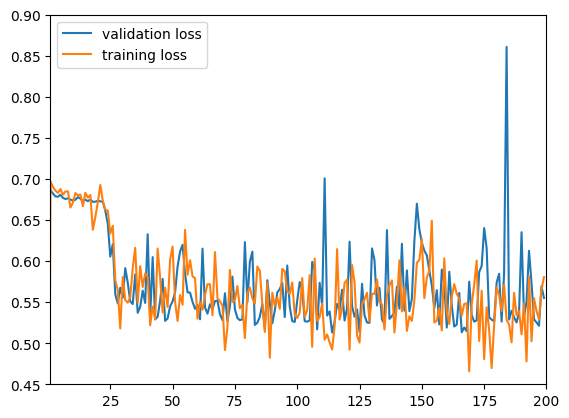

In [ ]:
plt.plot(word_val_losses, label='validation loss')
plt.plot(word_train_losses, label='training loss')

plt.xlim(1, 200)
plt.ylim(0.45, 0.9)
plt.legend()

# Section 2: Another classification: city names

Now let's work with another classification example! We will use Names of the Cities dataset. The task is to predict the country a city is in.



### **Dataset Description**

Like we have used in the previous homework before, this dataset has a list of city names and their countries as label. The following countries are included in the dataset.

| Index | id | Country |
|----------|----------|----------|
| 0 | af | Afghanistan |
| 1 | cn | China |
| 2 | de | Germany |
| 3 | fi | Finland |
| 4 | fr | France |
| 5 | in | India |
| 6 | ir | Iran |
| 7 | pk | Pakistan |
| 8 | za | South Africa |

We need to re-define our 'group' first, since there are now 9 categories. Let's name it as 'languages'.

In [ ]:
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]

Let's also take a look at the dataset. We have finished some preprocessing for you, but each country label is in a string form, while tensor only accepts integer.

In [ ]:
city_train_data_raw = readData("/content/", train=True)
city_val_data_raw = readData("/content/", train=False)

X_city, y_city_str = city_train_data_raw
X_val_city, y_val_city_str = city_val_data_raw

seed = 12
local_random = np.random.RandomState(seed)
print(X_city[local_random.choice(len(X_city), 5, replace=False)])
local_random = np.random.RandomState(seed)
print(y_city_str[local_random.choice(len(y_city_str), 5, replace=False)])

['nyarkheyl' 'daxikou' 'galupadeh' 'maohezi' 'airport road']
['af' 'cn' 'de' 'cn' 'ir']


In order to do multiclass classification with PyTorch, we need to pre-process `y_city_str`, using the index-id mapping table provided above:


In [ ]:
y_city = [languages.index(country) for country in y_city_str]
y_val_city = [languages.index(country) for country in y_val_city_str]

In [ ]:
assert y_city[10] == 0
assert y_city[10000] == 3
assert y_city[25000] == 8
assert y_val_city[10] == 0
assert y_val_city[100] == 1
assert y_val_city[500] == 5

In [ ]:
city_train_data = X_city, y_city
city_val_data = X_val_city, y_val_city

### **Remake the model and functions: from binary to multiclass**

The model and functions we used in the previous example is made for binary classification, where output classes are only 0 and 1. In this problem, we have 8 different categories. What should we change? We need to make our model accepts multiple outputs dimension, which includes fixing `RNN()`, `predict()`, `calculateAccuracy()`, and `run()` function.

Let's start with the RNN model first. We assumed there were only 2 categories in RNN(), but now we have more than that.

In [ ]:
class RNN_multi(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        '''
        TODO: Remake the __init__ function to adapt multiclass classification
        The function should accept various range of output size.

        Inputs:
            self: points to initialized object
            input_size: dimensions of input tensor
            hidden_size: dimensions of the hidden layer
            output_size: dimensions of the expected output tensor
        Returns:
            nothing, it initializes the RNN object
        '''
        super().__init__()
        self.hidden_size = hidden_size
        # Linear layer taking concatenated input and hidden state to the next hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Linear layer to map hidden state to output
        # A hidden layer in a neural network is between the input and output layers and captures patterns in the data by applying weights and activation functions.
        self.h2o = nn.Linear(hidden_size, output_size)
        # LogSoftmax activation for output (useful for classification tasks)
        # The softmax function converts a vector of values into a probability distribution, often used in multi-class classification to assign probabilities to different classes.
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
# TEST - it should accept different output size! (Should be fine if there is no error)
RNN_multi(1,1,1)
RNN_multi(10,10,10)

RNN_multi(
  (i2h): Linear(in_features=20, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

The `predict()` function we used was designed for binary classification only too. We need to fix how prediction is derived from `output` of the model.

In [ ]:
def predict_multi(model, X, y=None, loss_func=None):
    with torch.no_grad():
        model.eval()
        pred = []
        val_loss = []
        for ind in range(X.shape[0]):
            hidden = model.initHidden().to(device)
            val = lineToTensor(X[ind])
            for i in range(val.size()[0]):
                output, hidden = model(val[i], hidden)
            #   1. Get the index of the maximum value of the output tensor
            #   2. Append it to the pred list
            value, index = output.topk(1)
            pred.append(index.cpu().item())

            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_loss.append(loss_func(output, category_tensor).data.item())
    if y is not None and loss_func is not None:
        return sum(val_loss) / len(val_loss)
    return np.array(pred)

Let's also update `calculateAccuracy()` function, where `predict_multi()` shuould be updated.

In [ ]:
def calculateAccuracy_multi(model, X, y):
    preds = predict_multi(model, X)
    return accuracy_score(preds, y)

Finally, let's update `run()` function to address the changes we have made above.

In [ ]:
def run_multi(train_data, val_data, hidden_size, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data
    model = RNN_multi(input_size=len(all_letters), hidden_size=hidden_size, output_size=9)
    model = model.to(device)
    current_loss = 0
    train_losses = []
    val_losses = []

    for epoch in range(0, n_epochs):
        output, loss, line, category = trainOneEpoch(model,
                    criterion = loss_func,
                    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate),
                    X=X,
                    y=y)
        current_loss += loss


        if epoch % print_every == 0:
            #   1. make prediction
            #   2. compare with gold label to see right or wrong
            #   3. report the number of epoch, the percentage of completion, loss,...
            log_probabilities = output.cpu().data
            max_probability = max(log_probabilities)
            max_value, max_index = log_probabilities.topk(1)
            prediction = languages[max_index]
            correct = 'correct' if prediction == category else 'incorrect (True:%s)' % category
            print('Epoch %d (%d%%)  Loss: %.4f, Word: %s, Prediction: %s | %s' % (epoch, epoch / n_epochs * 100, loss, line, prediction, correct))

        if epoch % plot_every == 0:
            train_losses.append(current_loss/plot_every)
            current_loss= 0
            # Validation Loss
            val_losses.append(predict_multi(model, X_val, y_val, loss_func))

    torch.save(model.state_dict(), model_name)
    return train_losses, val_losses

### **Test the new model**

Let's test our model with these hyperparameters first. They are not great, but we will tune them later.

In [ ]:
city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 10,
                              n_epochs = 50000,
                              learning_rate = 0.01,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./city_RNN"
                            )

Epoch 0 (0%)  Loss: 2.1545, Word: kodean, Prediction: de | incorrect (True:7)
Epoch 5000 (10%)  Loss: 1.3268, Word: chinekalay, Prediction: af | incorrect (True:0)
Epoch 10000 (20%)  Loss: 0.5709, Word: xinzuotang, Prediction: cn | incorrect (True:1)
Epoch 15000 (30%)  Loss: 2.6979, Word: wulkau, Prediction: cn | incorrect (True:2)
Epoch 20000 (40%)  Loss: 1.4886, Word: gandah kotal, Prediction: af | incorrect (True:0)
Epoch 25000 (50%)  Loss: 0.6753, Word: filchendorf, Prediction: de | incorrect (True:2)
Epoch 30000 (60%)  Loss: 1.4627, Word: pyaungbin, Prediction: cn | incorrect (True:5)
Epoch 35000 (70%)  Loss: nan, Word: greenlaw crossing, Prediction: pk | incorrect (True:5)
Epoch 40000 (80%)  Loss: nan, Word: hallering, Prediction: pk | incorrect (True:4)
Epoch 45000 (90%)  Loss: nan, Word: gottwitz-wetteritz, Prediction: pk | incorrect (True:2)


In [ ]:
# Load saved model
test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_multi.load_state_dict(torch.load("./city_RNN"))

<ipython-input-45-aa438ae3306d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load("./city_RNN"))


<All keys matched successfully>

Here, we calculate validation accuracy and draw a training and validation loss plot.

In [ ]:
test_model_multi.eval()

X, y = city_val_data
val_acc = calculateAccuracy_multi(test_model_multi, X, y)

In [ ]:
val_acc

0.1111111111111111

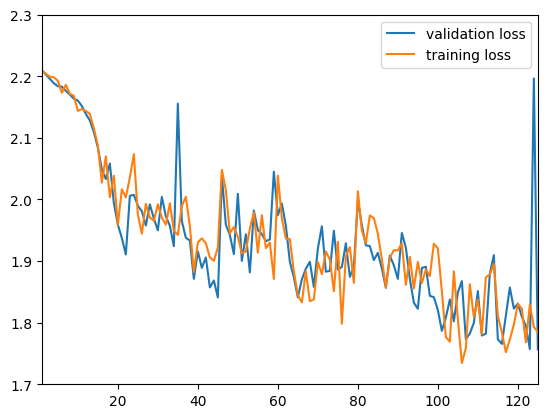

In [ ]:
plt.plot(city_val_losses, label='validation loss')
plt.plot(city_all_losses, label='training loss')

plt.xlim(1, 125)
plt.ylim(1.7, 2.3)
plt.legend()

### **Hyperparameter tuning**

The current set of hyperparameters will very likely to make our model generate `Nan` loss, and it often does not learn the data well. What is the problem? The main reason is the model we used in word classification is not suitable for this task. Our main goal in this section is improving the model with "hyperparameter tuning".

We now have 3 hyperparameters to tune:   
1. **learning_rate** represents how fast the model learn for each backpropagation. The higher a value, the faster a model converges. However if a learning rate is too high, it will cause a lot of problems like overshooting (can't converge, bouncing around the minimum) or divergence (loss goes to infinity).
2. **hidden_size** defines the size of the hidden layer in your RNN model. The larger the size, the more complex model can be (and slower).
3. **n_epochs** controls the number of epoch the model use for training. The more we train, the more it learns from training dataset (and takes longer time). Be careful for overfitting!

###Learning rate tunning

From the base hyperparameters we gave, adjust the learning_rate = {0.0002, 0.002 0.02} and compare the result.

In [ ]:
learning_rate = [0.0002, 0.002, 0.02]
train_loss = []
val_loss = []
acc = []

for lr in learning_rate:
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 10,
                              n_epochs = 50000,
                              learning_rate = lr,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = f"./city_RNN_lr{lr}"
                            )
  test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_lr{lr}"))

  test_model_multi.eval()

  X, y = city_val_data
  val_acc = calculateAccuracy_multi(test_model_multi, X, y)

  train_loss.append(city_all_losses)
  val_loss.append(city_val_losses)
  acc.append(val_acc)


Epoch 0 (0%)  Loss: 2.3981, Word: puzavci, Prediction: af | incorrect (True:8)
Epoch 5000 (10%)  Loss: 2.3394, Word: enkeldoorn, Prediction: ir | incorrect (True:8)
Epoch 10000 (20%)  Loss: 2.2820, Word: chando jaskani, Prediction: af | incorrect (True:7)
Epoch 15000 (30%)  Loss: 2.1847, Word: mirza seyyed mohammad, Prediction: ir | incorrect (True:0)
Epoch 20000 (40%)  Loss: 2.3669, Word: valreas, Prediction: af | incorrect (True:4)
Epoch 25000 (50%)  Loss: 2.4072, Word: alfredo chavez, Prediction: in | incorrect (True:4)
Epoch 30000 (60%)  Loss: 2.1633, Word: kafr farouqi, Prediction: cn | incorrect (True:0)
Epoch 35000 (70%)  Loss: 2.1892, Word: mian khel kirri, Prediction: cn | incorrect (True:7)
Epoch 40000 (80%)  Loss: 2.2806, Word: martin-chapon, Prediction: ir | incorrect (True:4)
Epoch 45000 (90%)  Loss: 2.1805, Word: dehmazin, Prediction: fi | incorrect (True:2)


<ipython-input-56-c206cba36017>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_lr{lr}"))


Epoch 0 (0%)  Loss: 2.3763, Word: jubainville, Prediction: ir | incorrect (True:4)
Epoch 5000 (10%)  Loss: 2.1060, Word: lunkkaus, Prediction: za | incorrect (True:3)
Epoch 10000 (20%)  Loss: 2.1213, Word: wangkouchen, Prediction: de | incorrect (True:1)
Epoch 15000 (30%)  Loss: 1.3784, Word: kogbwendehun, Prediction: de | incorrect (True:2)
Epoch 20000 (40%)  Loss: 1.6802, Word: huttusenniemi, Prediction: fi | incorrect (True:3)
Epoch 25000 (50%)  Loss: 1.5915, Word: ghway guzah, Prediction: cn | incorrect (True:0)
Epoch 30000 (60%)  Loss: 0.8755, Word: dahan-e nayak, Prediction: af | incorrect (True:0)
Epoch 35000 (70%)  Loss: 1.0952, Word: xichentun, Prediction: cn | incorrect (True:1)
Epoch 40000 (80%)  Loss: 1.8220, Word: kaacaviran, Prediction: pk | incorrect (True:6)
Epoch 45000 (90%)  Loss: 1.9597, Word: mesnil-eudin, Prediction: de | incorrect (True:5)


<ipython-input-56-c206cba36017>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_lr{lr}"))


Epoch 0 (0%)  Loss: 2.3715, Word: morillon, Prediction: fi | incorrect (True:4)
Epoch 5000 (10%)  Loss: nan, Word: paso de la palma, Prediction: pk | incorrect (True:2)
Epoch 10000 (20%)  Loss: nan, Word: muikkula, Prediction: pk | incorrect (True:3)
Epoch 15000 (30%)  Loss: nan, Word: khwajah shahab, Prediction: pk | incorrect (True:0)
Epoch 20000 (40%)  Loss: nan, Word: ventas de garriel, Prediction: pk | incorrect (True:2)
Epoch 25000 (50%)  Loss: nan, Word: khojari babar, Prediction: pk | incorrect (True:7)
Epoch 30000 (60%)  Loss: nan, Word: bidhar, Prediction: pk | incorrect (True:7)
Epoch 35000 (70%)  Loss: nan, Word: san juan de tamon, Prediction: pk | incorrect (True:2)
Epoch 40000 (80%)  Loss: nan, Word: lunio sand, Prediction: pk | incorrect (True:7)
Epoch 45000 (90%)  Loss: nan, Word: kefr gani, Prediction: pk | incorrect (True:4)


<ipython-input-56-c206cba36017>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_lr{lr}"))


[[0.009592219352722168, 2.218321446895599, 2.2102278232574464, 2.2109728407859803, 2.2246695847511293, 2.208070538520813, 2.2092888531684873, 2.2176516990661623, 2.2242263684272765, 2.202252311706543, 2.202599781990051, 2.2084212098121645, 2.2154473152160645, 2.214575432777405, 2.211917844772339, 2.2206320486068725, 2.202086194038391, 2.2286525444984435, 2.2063466262817384, 2.2054111437797546, 2.205230812549591, 2.205687671661377, 2.2009274253845215, 2.2085780391693115, 2.21214253282547, 2.2185651874542236, 2.2160193819999696, 2.2044174070358276, 2.2095550684928895, 2.2056049070358275, 2.2245214376449587, 2.1975344829559327, 2.2042970151901247, 2.2083721580505373, 2.2090236368179323, 2.2103515787124635, 2.210312891960144, 2.203388174057007, 2.1969159145355226, 2.2160482006073, 2.210188063621521, 2.2032200260162353, 2.2088330717086793, 2.1996680183410646, 2.2016288957595824, 2.2128686046600343, 2.187555883407593, 2.199191611289978, 2.194042380332947, 2.2035908927917482, 2.21693616485595

In [ ]:
acc

[0.13111111111111112, 0.3511111111111111, 0.1111111111111111]

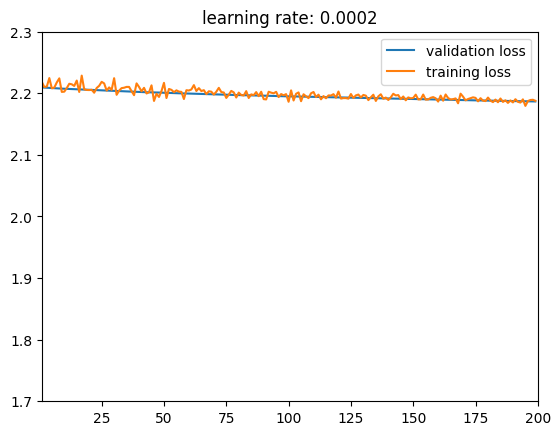

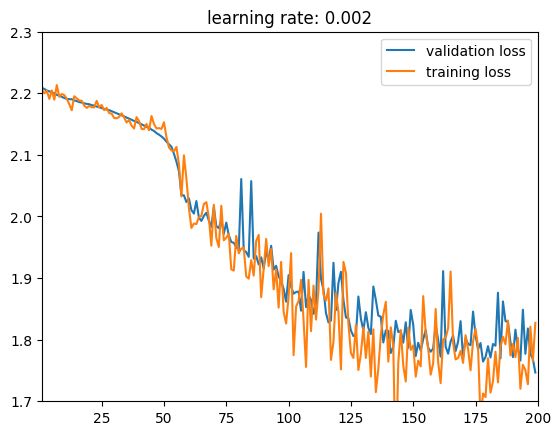

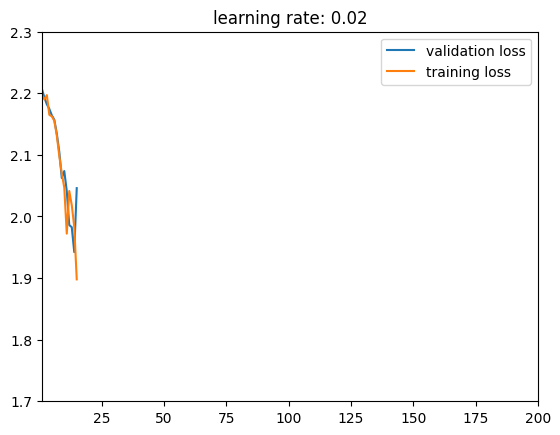

In [ ]:
for i, lr in enumerate(learning_rate):
  plt.plot(val_loss[i], label='validation loss')
  plt.plot(train_loss[i], label='training loss')

  plt.xlim(1, 200)
  plt.ylim(1.7, 2.3)
  plt.title(f"learning rate: {lr}")
  plt.legend()
  plt.show()

After running models with learning rates of [0.0002, 0.002, 0.02], the accuracy and losses point to 0.002 being the optimal value. Its accuracy of 0.3511 outperforms the accuracy of the model with rates 0.0002 and 0.02, having accuracies 0.1311 and 0.1111, respectively. We can also observe in the plot of the training and validation loss that a learning rate of 0.0002 does not demonstrate much of a drop in loss and stays at around 2.2 throughout, suggesting that the model is not learning features well at all. This learning rate is too small, as it is converging way too slowly. Additionally, the model with a learning rate of 0.02 has a loss that drops very quickly, then produces many Nan values. This may be because the rate is too large so that it doesn’t learn values correctly and may even overshoot or diverge.


### Hidden layer size tunning

With the best learning rate you have, build models with hidden_size = {10, 50, 100} and compare the result.

In [ ]:

hidden_size = [10, 50, 100]
train_loss = []
val_loss = []
acc = []

for hs in hidden_size:
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = hs,
                              n_epochs = 50000,
                              learning_rate = 0.002,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = f"./city_RNN_hs{hs}"
                            )
  test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=hs, output_size=len(languages)).to(device)
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_hs{hs}"))

  test_model_multi.eval()

  X, y = city_val_data
  val_acc = calculateAccuracy_multi(test_model_multi, X, y)

  train_loss.append(city_all_losses)
  val_loss.append(city_val_losses)
  acc.append(val_acc)

Epoch 0 (0%)  Loss: 2.0300, Word: kandara, Prediction: in | incorrect (True:7)
Epoch 5000 (10%)  Loss: 2.1540, Word: khirsala, Prediction: za | incorrect (True:3)
Epoch 10000 (20%)  Loss: 2.1132, Word: sanzalai, Prediction: pk | incorrect (True:8)
Epoch 15000 (30%)  Loss: 2.2321, Word: aflu, Prediction: cn | incorrect (True:0)
Epoch 20000 (40%)  Loss: 2.3871, Word: gyr khader, Prediction: pk | incorrect (True:2)
Epoch 25000 (50%)  Loss: 1.7087, Word: shin mandai kili, Prediction: pk | incorrect (True:7)
Epoch 30000 (60%)  Loss: 3.1115, Word: nejey, Prediction: fr | incorrect (True:6)
Epoch 35000 (70%)  Loss: 2.1378, Word: gulchsheim, Prediction: in | incorrect (True:2)
Epoch 40000 (80%)  Loss: 5.1706, Word: kafr al abhar, Prediction: af | incorrect (True:4)
Epoch 45000 (90%)  Loss: 1.7498, Word: zamblefla, Prediction: fi | incorrect (True:8)


<ipython-input-62-06a86d1150db>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_hs{hs}"))


Epoch 0 (0%)  Loss: 2.2266, Word: fryazino, Prediction: fi | incorrect (True:4)
Epoch 5000 (10%)  Loss: 2.2213, Word: jarb al fiqr, Prediction: fr | incorrect (True:3)
Epoch 10000 (20%)  Loss: 2.2143, Word: zavits, Prediction: fr | incorrect (True:8)
Epoch 15000 (30%)  Loss: 1.0883, Word: lashkaribazar, Prediction: pk | incorrect (True:0)
Epoch 20000 (40%)  Loss: 1.9208, Word: zakholyn, Prediction: pk | incorrect (True:8)
Epoch 25000 (50%)  Loss: 1.5688, Word: arun qi, Prediction: cn | incorrect (True:1)
Epoch 30000 (60%)  Loss: 0.9266, Word: pirila, Prediction: fi | incorrect (True:3)
Epoch 35000 (70%)  Loss: 0.8656, Word: zamow, Prediction: za | incorrect (True:8)
Epoch 40000 (80%)  Loss: 3.2537, Word: chashmah-ye maskin, Prediction: za | incorrect (True:5)
Epoch 45000 (90%)  Loss: 1.6690, Word: chareq, Prediction: ir | incorrect (True:6)


<ipython-input-62-06a86d1150db>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_hs{hs}"))


Epoch 0 (0%)  Loss: 2.1677, Word: ashmarina, Prediction: za | incorrect (True:5)
Epoch 5000 (10%)  Loss: 2.0720, Word: svedja, Prediction: fi | incorrect (True:3)
Epoch 10000 (20%)  Loss: 2.0547, Word: taschenberg, Prediction: cn | incorrect (True:2)
Epoch 15000 (30%)  Loss: 1.6569, Word: chatri, Prediction: pk | incorrect (True:7)
Epoch 20000 (40%)  Loss: 2.0721, Word: guaillavinto, Prediction: fi | incorrect (True:5)
Epoch 25000 (50%)  Loss: 1.5199, Word: zabula, Prediction: za | incorrect (True:8)
Epoch 30000 (60%)  Loss: 1.2407, Word: frausseilles, Prediction: fr | incorrect (True:4)
Epoch 35000 (70%)  Loss: 2.0568, Word: surin, Prediction: in | incorrect (True:6)
Epoch 40000 (80%)  Loss: 0.7057, Word: gordejken, Prediction: de | incorrect (True:2)
Epoch 45000 (90%)  Loss: 1.3280, Word: fitch point, Prediction: in | incorrect (True:5)


<ipython-input-62-06a86d1150db>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_hs{hs}"))


In [ ]:
acc

[0.3433333333333333, 0.4122222222222222, 0.38555555555555554]

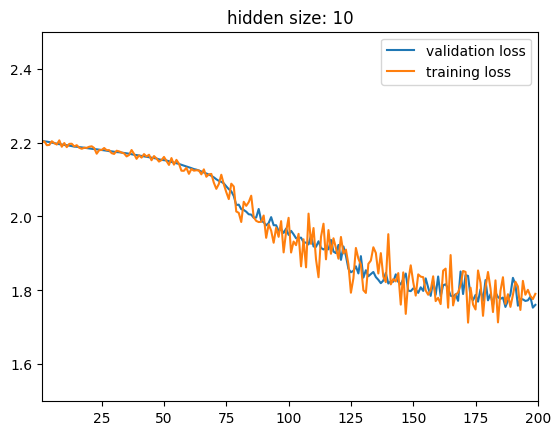

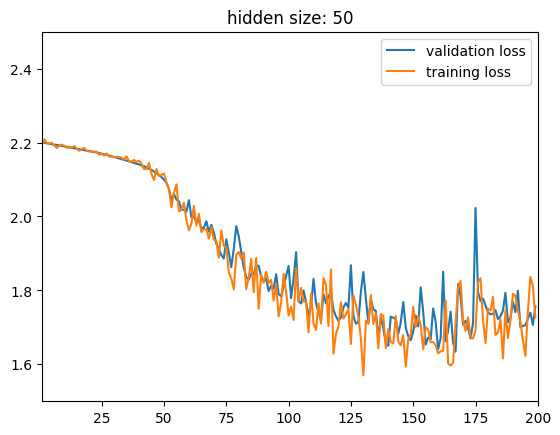

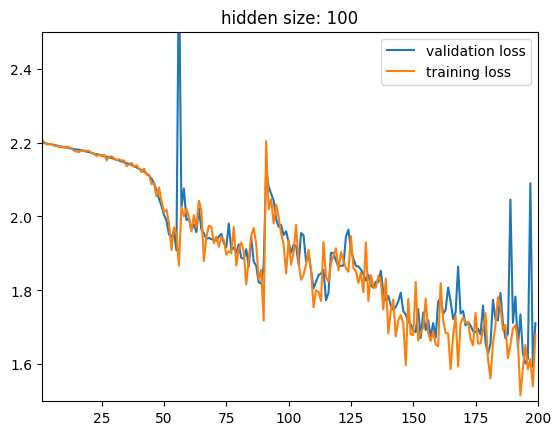

In [ ]:
for i, hs in enumerate(hidden_size):
  plt.plot(val_loss[i], label='validation loss')
  plt.plot(train_loss[i], label='training loss')

  plt.xlim(1, 200)
  plt.ylim(1.5, 2.5)
  plt.title(f"hidden size: {hs}")
  plt.legend()
  plt.show()

After running models with hidden layer sizes of 10, 50, and 100, the accuracy and losses point to 50 being the optimal size. It has an accuracy of 0.4122, which is higher than the two other hidden layer sizes with accuracies 0.3433 and 0.3855. Additionally, we can look at the plot of the training and validation loss and see that the model with hidden layer size 50 has a nice dropoff of loss at around 12500 epochs (50 on the x-axis), meaning that it is learning features and representations pretty well. The validation and training loss have pretty similar trends throughout as well, which is good so that the model can perform well on new data. The model with hidden size 10 has a similar looking plot which is good, but the loss doesn’t drop as far down as the optimal one which may mean it isn’t learning as quickly. The hidden size 100 plot has a couple points where the validation loss spikes, which could mean that it’s overfitting due to the complexity of the network and the model performs poorly on new data.

### Epoch tuning

With the best learnign rate and hidden_size you got, adjust the model with epoch = {1000, 50000, 100000} and compare the result.

In [ ]:
epochs = [1000, 50000, 100000]
train_loss = []
val_loss = []
acc = []

for epoch in epochs:
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 50,
                              n_epochs = epoch,
                              learning_rate = 0.002,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = f"./city_RNN_epoch{epoch}"
                            )
  test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size= 50, output_size=len(languages)).to(device)
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_epoch{epoch}"))

  test_model_multi.eval()

  X, y = city_val_data
  val_acc = calculateAccuracy_multi(test_model_multi, X, y)

  train_loss.append(city_all_losses)
  val_loss.append(city_val_losses)
  acc.append(val_acc)

Epoch 0 (0%)  Loss: 2.1178, Word: livadia de coaste, Prediction: de | incorrect (True:2)


<ipython-input-68-5fce1cfd1d13>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_epoch{epoch}"))


Epoch 0 (0%)  Loss: 2.3332, Word: ku-ndlunkulu, Prediction: pk | incorrect (True:8)
Epoch 5000 (10%)  Loss: 2.1665, Word: tirunallar, Prediction: in | incorrect (True:6)
Epoch 10000 (20%)  Loss: 2.2072, Word: sekeh ravan, Prediction: cn | incorrect (True:6)
Epoch 15000 (30%)  Loss: 2.0405, Word: dziras, Prediction: fr | incorrect (True:6)
Epoch 20000 (40%)  Loss: 2.2506, Word: junyetun, Prediction: de | incorrect (True:1)
Epoch 25000 (50%)  Loss: 3.5002, Word: deh-i-qazi, Prediction: pk | incorrect (True:2)
Epoch 30000 (60%)  Loss: 1.8410, Word: zahareuca, Prediction: fi | incorrect (True:8)
Epoch 35000 (70%)  Loss: 1.7537, Word: zarghun shahr, Prediction: pk | incorrect (True:8)
Epoch 40000 (80%)  Loss: 2.2717, Word: la halerie, Prediction: pk | incorrect (True:4)
Epoch 45000 (90%)  Loss: 1.5729, Word: mafinndo, Prediction: in | incorrect (True:3)


<ipython-input-68-5fce1cfd1d13>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_epoch{epoch}"))


Epoch 0 (0%)  Loss: 2.1151, Word: conubie mouth, Prediction: fi | incorrect (True:8)
Epoch 5000 (5%)  Loss: 2.2196, Word: grossbockenheim, Prediction: pk | incorrect (True:2)
Epoch 10000 (10%)  Loss: 2.1637, Word: petit-sautour, Prediction: za | incorrect (True:4)
Epoch 15000 (15%)  Loss: 1.7602, Word: soliskyla, Prediction: fi | incorrect (True:3)
Epoch 20000 (20%)  Loss: 1.5880, Word: leubengrund, Prediction: cn | incorrect (True:2)
Epoch 25000 (25%)  Loss: 1.7169, Word: zardband, Prediction: za | incorrect (True:8)
Epoch 30000 (30%)  Loss: 2.3993, Word: tabanca grande, Prediction: za | incorrect (True:2)
Epoch 35000 (35%)  Loss: 2.8233, Word: deh-e molla mohammad, Prediction: af | incorrect (True:2)
Epoch 40000 (40%)  Loss: 3.0581, Word: vintervagen, Prediction: cn | incorrect (True:3)
Epoch 45000 (45%)  Loss: 0.5913, Word: yangfan, Prediction: cn | incorrect (True:1)
Epoch 50000 (50%)  Loss: 1.2206, Word: siparinmaki, Prediction: fi | incorrect (True:3)
Epoch 55000 (55%)  Loss: 2.4

<ipython-input-68-5fce1cfd1d13>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_multi.load_state_dict(torch.load(f"./city_RNN_epoch{epoch}"))


In [ ]:
acc

[0.11888888888888889, 0.3511111111111111, 0.41]

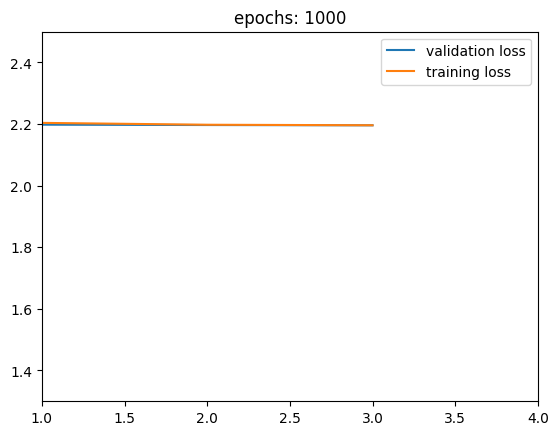

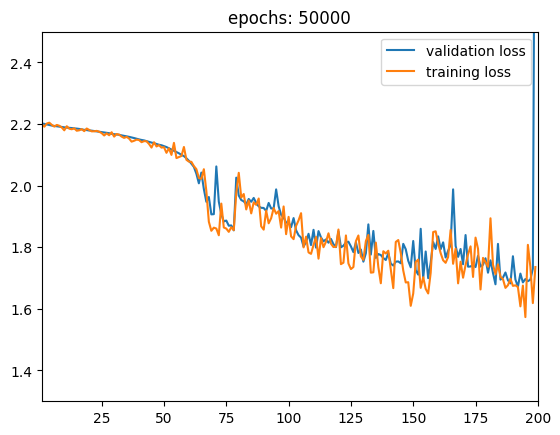

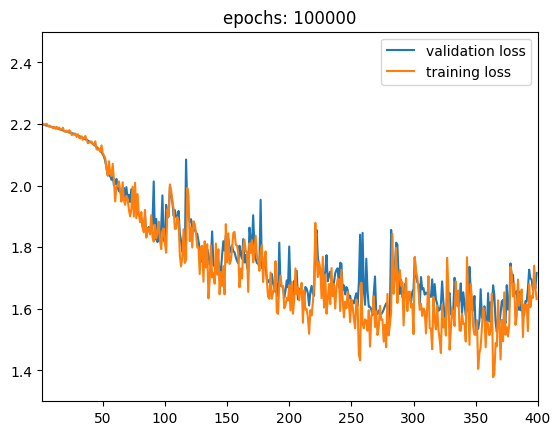

In [ ]:
for i, epoch in enumerate(epochs):
  plt.plot(val_loss[i], label='validation loss')
  plt.plot(train_loss[i], label='training loss')
  plt.xlim(1, epoch/250)
  plt.ylim(1.3, 2.5)
  plt.title(f"epochs: {epoch}")
  plt.legend()
  plt.show()

After running models with number of epochs being 1000, 50000, and 100000, the accuracy and loss actually point to 100000 being the most optimal. The accuracy is 0.41, while the other epoch sizes are 0.3511 and 0.1188. When the epoch value is too high, there is a risk of overfitting, put the plot for validation loss is pretty close to the training loss throughout the epochs. There are a few spikes in the validation loss with 100000 epochs, but it isn’t a considerably large amount more than we are seeing in the 50000 epoch models. Validation loss also dips down to 1.6 in the 100000 model, while it stays up at around 1.8 for the 50000 model.
